Analisis datos Chilecracia, excluyendo participantes anomalos

Pasos de limpieza:

-Se excluyeron participantes con mas de 500 votos

-Se excluyeron los participantes identificados en el notebook anterior (Analisis_Chilecracia.ipynb) como "anomalos"

-Se realizo un subsampling aleatorio de la votacion de la medida 23 vs la 87 (nueva constitucion vs sueldo minimo), dejandola en un promedio de 900 votaciones (en linea con el resto de pares)

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import cm

import scipy
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

plt.style.use('ggplot')

# Descarga de datos

Primero cargamos la data descargada desde https://chilecracia.org/datos
Actualmente trabajamos con la descarga generada el 31/10/2019.
Ademas se bajan los participantes anomalos identificados en el analisis anterior (Analisis Chilecracia.ipynb)

In [2]:
fecha_dataset = '20191031'
data_option = pd.read_csv('data/chilecracia_ids_{}.tsv'.format(fecha_dataset),  sep="\t")
data_people = pd.read_csv('data/data_people_dump_{}.csv'.format(fecha_dataset))
data_survey = pd.read_csv('data/data_survey_dump_{}.csv'.format(fecha_dataset))
weird_users_total = pd.read_pickle('data/participantes_anomalos.pkl')

In [3]:
data_option.head(3)

,id,nombre_corto,nombre_largo,topico
0,1,Farmacias,Creación de Farmacias Populares,Salud
1,3,Cárcel Cohecho,Cárcel Efectiva para Soborno y Cohecho,Justicia
2,4,Retiro AFP,Retiro Anticipado Fondo de Pensiones,Pensiones


In [4]:
data_people.head(3)

,uuid,sex,age,region
0,db8e438c-4b05-4684-b168-667a1236411f,Masculino,24,Biobío
1,8bd42737-b140-4db8-af4c-59839922129a,Masculino,27,Biobío
2,06656cd5-a184-4f21-b947-2b82f83625f6,Femenino,27,Biobío


In [5]:
data_survey.head(3)

,uuid,option_a,option_b,selected
0,b72d8a25-746d-4689-a479-886bad5dfb0f,23,70,23
1,5892385f-3b94-4eb8-9dd7-98e3280a743c,23,87,23
2,0a76bdbc-9e04-4d1d-8a31-baf6884d575e,23,87,23


In [6]:
weird_users_total.head(3)

,x,y,sex,age,region,0,1,2,3,4,5,6,7,8,9,cluster
uuid,,,,,,,,,,,,,,,,
003d20b6-06ed-481e-8817-4fe8a4fa9214,-14.784542,5.732900,NaN,NaN,NaN,0.019322,0.470511,-0.501753,0.061045,-0.077112,-0.003335,0.006763,0.013119,0.022451,0.015777,1
00edb33b-5be4-44fd-bb8c-f5c4273e9c55,-15.026545,5.269154,NaN,NaN,NaN,0.019322,0.470511,-0.501753,0.061045,-0.077112,-0.003335,0.006763,0.013119,0.022451,0.015777,1
00f4dfc7-a64a-4f4b-ad0f-d2e28bcdd48b,-14.472333,6.275898,NaN,NaN,NaN,0.019322,0.470511,-0.501753,0.061045,-0.077112,-0.003335,0.006763,0.013119,0.022451,0.015777,1


In [7]:
# resumen tablas
print(data_people.info())
print(data_option.info())
print(data_survey.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44186 entries, 0 to 44185
Data columns (total 4 columns):
uuid      44186 non-null object
sex       44186 non-null object
age       44186 non-null int64
region    44186 non-null object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 4 columns):
id              129 non-null int64
nombre_corto    129 non-null object
nombre_largo    129 non-null object
topico          129 non-null object
dtypes: int64(1), object(3)
memory usage: 4.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642614 entries, 0 to 3642613
Data columns (total 4 columns):
uuid        object
option_a    int64
option_b    int64
selected    int64
dtypes: int64(3), object(1)
memory usage: 111.2+ MB
None


En resumen son 44.186 participantes, 129 propuestas, 3.642.614 selecciones de pares

# Preprocesamiento datos

Creamos estructuras de datos necesarias para el analisis

In [8]:
# crea diccionario con pares {id: nombre_largo} para posterior uso
data_option_dict = dict(zip(data_option.id, data_option.nombre_largo))

In [9]:
aux_count = data_survey.groupby(by='uuid').count()['option_a']
over_index = aux_count[aux_count > 500].to_frame().sort_values(by = 'option_a', ascending = False)

# preparamos la tabla de preguntas
data_survey['uuid'] = data_survey['uuid'].astype(str) 

# filtra uuids detectadas como anomalas
data_survey= data_survey[~data_survey['uuid'].isin(weird_users_total.index)].copy()
data_survey= data_survey[~data_survey['uuid'].isin(over_index.index)].copy()

# GENERA SUBSAMPLING ALEATORIO DE VOTOS ENTRE 23 y 87

#filtra pares 23 vs 87
data_anomalo_1 = data_survey[(data_survey['option_a'] == 23) & (data_survey['option_b'] == 87)].copy()
data_anomalo_2 = data_survey[(data_survey['option_b'] == 23) & (data_survey['option_a'] == 87)].copy()

data_survey = data_survey[~((data_survey['option_a'] == 23) & (data_survey['option_b'] == 87))].copy()
data_survey = data_survey[~((data_survey['option_b'] == 23) & (data_survey['option_a'] == 87))].copy()

#agrega de vuelta 900 muestras aleatoreas de elecciones entre la 23 y 87
anomalos = pd.concat([data_anomalo_1, data_anomalo_2], axis = 0).sample(900)

data_survey = pd.concat([data_survey, anomalos], axis = 0)

In [10]:
# agregamos columna "unselected" para guardar las opciones no elegidas en cada desicion
data_survey['unselected'] = data_survey.apply(lambda row: row['option_a'] 
                                              if row['option_b'] == row['selected'] 
                                              else row['option_b'],  axis=1)

# deja solo elementos con seleccion definida (no cero en campo selected)
data_survey = data_survey[data_survey['selected'] != 0].copy()
data_survey.shape

(3076902, 5)

In [11]:
# genera lista de participantes (uuid) y propuestas unicas
option_id = sorted(data_survey['selected'].unique())
uuid = sorted(data_survey['uuid'].unique())
print('numero de propuestas votadas unicas', len(option_id))
print('numero de participantes unicos', len(uuid))

numero de propuestas votadas unicas 90
numero de participantes unicos 57326


ojo que a pesar de haber 129 propuestas, el dataset de pares de votacion incluye solo las 90 originales

In [12]:
# genera matriz usuario/voto (conteo)
#crea matriz participante, propuesta
data_matrix = pd.DataFrame(0, index=uuid, columns=option_id)
data_matrix.index.name = 'uuid'

In [13]:
# llena la matriz con +1 en el caso votado y -1 en el que perdio
for index, row in tqdm(data_survey.iterrows(), total = len(data_survey)):
    data_matrix.at[row['uuid'], row['selected']] = 1 + data_matrix.loc[row['uuid'], row['selected']] 
    data_matrix.at[row['uuid'], row['unselected']] = -1 + data_matrix.loc[row['uuid'], row['unselected']] 

100%|██████████| 3076902/3076902 [13:16<00:00, 3862.33it/s]


In [14]:
data_matrix.head()

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
uuid,,,,,,,,,,,,,,,,,,,,,
000057c7-295c-4a61-8f62-76aff62bf079,-1,1,1,-1,2,0,-2,1,0,1,...,-1,1,1,0,2,0,-1,2,0,0
000059b8-10b9-4f74-9c01-80bd2c48f509,0,1,-2,6,-6,4,2,-1,-2,-5,...,-2,-5,-3,1,-2,-2,1,-5,0,3
00032199-2183-48c0-8f0d-ac37dc8ece60,-2,-2,-1,0,-6,5,1,0,-3,-3,...,0,2,3,0,0,-1,-2,1,3,2
00058f3f-637b-4f30-9d78-0b8d63183dfe,-1,3,0,0,-1,-1,1,0,0,1,...,3,2,3,0,2,1,0,0,0,2
000629ba-44c0-47c1-b2b2-abe4f0ee808f,-1,-1,0,0,0,0,0,0,-2,1,...,1,-1,0,0,0,1,0,1,0,-1


In [15]:
# genera matrix rankeada, entregando el percentil del puntaje 
# se le resta 0.5 para diferenciar pares con voto sobre la mediana y bajo la media
data_matrix_rank = data_matrix.rank(axis=1, pct=True) - 0.5
data_matrix_rank.head()

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
uuid,,,,,,,,,,,,,,,,,,,,,
000057c7-295c-4a61-8f62-76aff62bf079,-0.327778,0.338889,0.338889,-0.327778,0.477778,0.005556,-0.466667,0.338889,0.005556,0.338889,...,-0.327778,0.338889,0.338889,0.005556,0.477778,0.005556,-0.327778,0.477778,0.005556,0.005556
000059b8-10b9-4f74-9c01-80bd2c48f509,0.000000,0.100000,-0.216667,0.483333,-0.466667,0.400000,0.211111,-0.105556,-0.216667,-0.416667,...,-0.216667,-0.416667,-0.305556,0.100000,-0.216667,-0.216667,0.100000,-0.416667,0.000000,0.311111
00032199-2183-48c0-8f0d-ac37dc8ece60,-0.272222,-0.272222,-0.122222,0.044444,-0.488889,0.477778,0.188889,0.044444,-0.394444,-0.394444,...,0.044444,0.272222,0.366667,0.044444,0.044444,-0.122222,-0.272222,0.188889,0.366667,0.272222
00058f3f-637b-4f30-9d78-0b8d63183dfe,-0.238889,0.455556,0.016667,0.016667,-0.238889,-0.238889,0.266667,0.016667,0.016667,0.266667,...,0.455556,0.394444,0.455556,0.016667,0.394444,0.266667,0.016667,0.016667,0.016667,0.394444
000629ba-44c0-47c1-b2b2-abe4f0ee808f,-0.394444,-0.394444,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,-0.477778,0.405556,...,0.405556,-0.394444,0.011111,0.011111,0.011111,0.405556,0.011111,0.405556,0.011111,-0.394444


# SVD ANALISIS

Para analizar la matriz participante/propuesta, primero generamos una descomposicion tipo SVD (Singular Value Decomposition https://en.wikipedia.org/wiki/Singular_value_decomposition).
Donde la matriz de n participes y m propuestas se descompone en una de nxk y otra de kxm, sinendo k el numero de "temas" subyacentes que resumen la totalidad de propuestas.

Una forma de entender estos "temas" es que cada uno representa un votante tipo, el cual tiene preferencia de algunas propuestas sobre otras. Cada votante es una combinacion de estos "tipos de votante", el cual queda determinado por los pesos de cada participante a cada tema.

In [16]:
from sklearn.decomposition import TruncatedSVD

In [17]:
# creamos modelo SVD de 10 componentes y lo entrenamos con la matrix rankeada
svd = TruncatedSVD(n_components=10, n_iter=100, random_state=42)
user_topic = svd.fit_transform(data_matrix_rank.values)  
topic_option = svd.components_

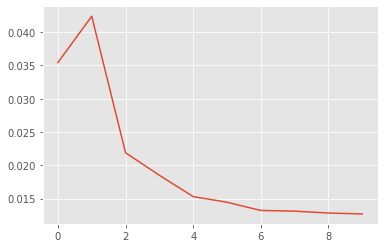

In [18]:
plt.plot(svd.explained_variance_ratio_)
plt.show()

Vemos que los 6 primeros temas son los que explican el mayor porcentaje de varianza, por lo que nos enfocaremos  en ellos

In [19]:
cols_topic = [data_option_dict[x] for x in data_matrix_rank.columns]
topic_sumary_df = pd.DataFrame(topic_option, columns = cols_topic).transpose()
user_topic_df = pd.DataFrame(user_topic, index = data_matrix_rank.index)

In [20]:
def topic_analisis(n, top_elements, topic_sumary, user_topic):
    
    top_val = topic_sumary[n].sort_values(ascending=False).iloc[:top_elements]
    bottom_val = topic_sumary[n].sort_values(ascending=False).iloc[-top_elements:]

    data_aux = pd.concat([top_val, bottom_val], axis = 0).sort_values(ascending=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('Relevancia medidas y distribucion participantes en tema {}'.format(str(n+1)))
    
    cmap = cm.get_cmap('rainbow')
    
    data_aux.plot(kind='barh', color=plt.cm.rainbow(data_aux), ax = ax1)
    a = plt.hist(pd.DataFrame(user_topic)[n], bins=100, density=True)

    plt.show()

    print(pd.DataFrame(user_topic)[n].describe())

## Tema 1

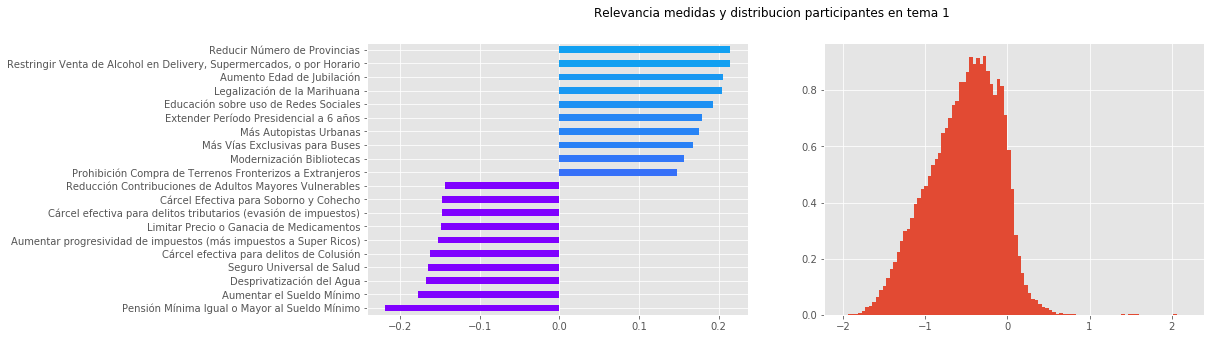

count    57326.000000
mean        -0.528056
std          0.428599
min         -2.023611
25%         -0.820253
50%         -0.482950
75%         -0.204644
max          2.187267
Name: 0, dtype: float64


In [21]:
topic_analisis(0, 10, topic_sumary_df, user_topic)

El primer tema o tipo de votante se podria resumir como todos los elementos de prioridad "transversal" vs aquellos de relevancia "secundaria" o impopular. (ojo que en este caso el algoritmo los definio de manera inversa, la mayoria de los participantes poseen un valor negativo en esta dimension, lo que significa apoyo de las medidas con pesos negativos)

Se ve que la mayoria apoya medidas en linea con aumento al estado de bienestar (pensiones, salud), mejorar la redistribucion del ingreso (impuestos progresivos), penalizacion de delitos politico/economicos.

Por el contrario, dentro de las medidas "secundarias" se ven temas relativos a ordenamiento territorial, redes sociales, marihuana, periodo presindencial.

IMPORTANTE: AL COMPARAR ESTOS RESULTADOS CON LOS DEL MODELO SIN AJUSTAR POR ELEMENTOS ANOMALOS, LA RELEVANCIA DE LA NUEVA CONSTITUCION SALE DE LAS TOP 10, MIENTRAS QUE EL AUMENTO DEL SUELDO MINIMO SIGUE SIENDO DE ALTA RELEVANCIA (TOP 2)

## Tema 2

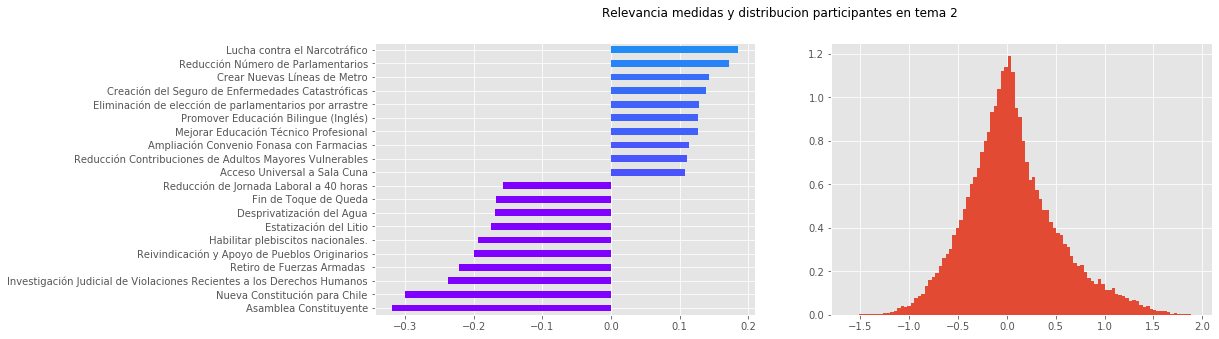

count    57326.000000
mean         0.055291
std          0.468742
min         -1.619147
25%         -0.241630
50%          0.013999
75%          0.309749
max          1.921630
Name: 1, dtype: float64


In [22]:
topic_analisis(1, 10, topic_sumary_df, user_topic)

El segundo tema o tipo de votante puede resumirse como aquel preferiere medidas "pragmaticas" sobre medidas "politicas".

En el extremo "politico" se ven temas consituyentes (nueva constitucion, asamblea constituyente, plebiscitos), oposicion a la situacion militar/policial (retiro de FFAA, investigacion DDHH, fin toque de queda) y causas historico/culturales (pueblos originarios, nacionalizaciones)

En el extremo "pragmatico" se ve fuerte el sueldo minimo, seguridad, transporte, salud y educacion

La distribucion muestra un sesgo "pragmatico" versus "politico"

IMPORTANTE: AL COMPARAR ESTOS RESULTADOS CON LOS DEL MODELO SIN AJUSTAR POR ELEMENTOS ANOMALOS SE VE UN CAMBIO EN EL SESGO DESDE LO "POLITICO" A LO "PRAGMATICO". EVIDENCIANDO EL SESGO DE LOS VOTOS ANOMALOS

## Tema 3

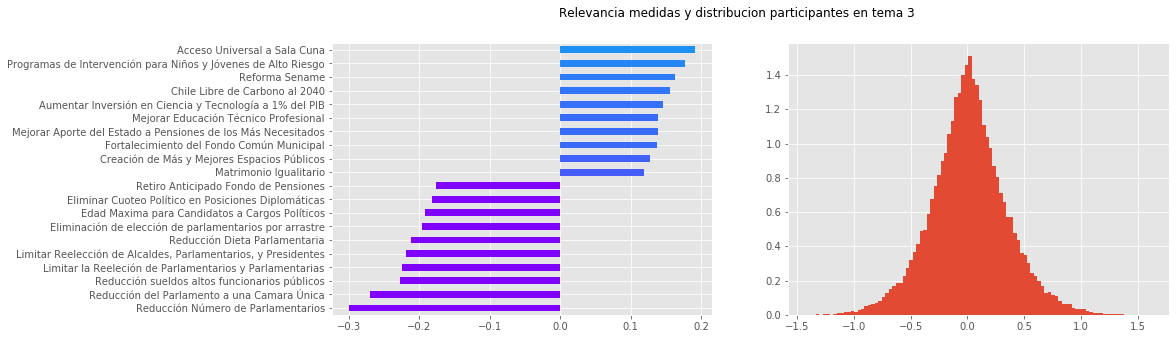

count    57326.000000
mean         0.012218
std          0.336840
min         -1.424228
25%         -0.191038
50%          0.009256
75%          0.210419
max          1.620260
Name: 2, dtype: float64


In [23]:
topic_analisis(2, 10, topic_sumary_df, user_topic)

El tercer tema o tipo de votante puede resumirse como aquel que promueve medidas sobre "juventud, educacion y bienestar" versus "reduccion y control de la clase piolitica"

El eje de "Juventud, educacion, y bienestar" se ven temas de apoyo a menores (sala cuna, sename, jovenes de alto riesgo), fortalecimiento a la educacion y las ciencias, ademas de mejoras al estados de bienestar (fondo comun municipal, pensiones, espacios publicos, etc).

El eje de reduccion de la clase politica se enfoca en limitar las capacidades y privilegios de ésta.

La distribucion entre participantes se puede ver bastante balanceada, con un pequeño sesgo a valorar elementos de "juventud, educacion y bienestar" por sobre la "reduccion y control de la clase politica"

## Tema 4

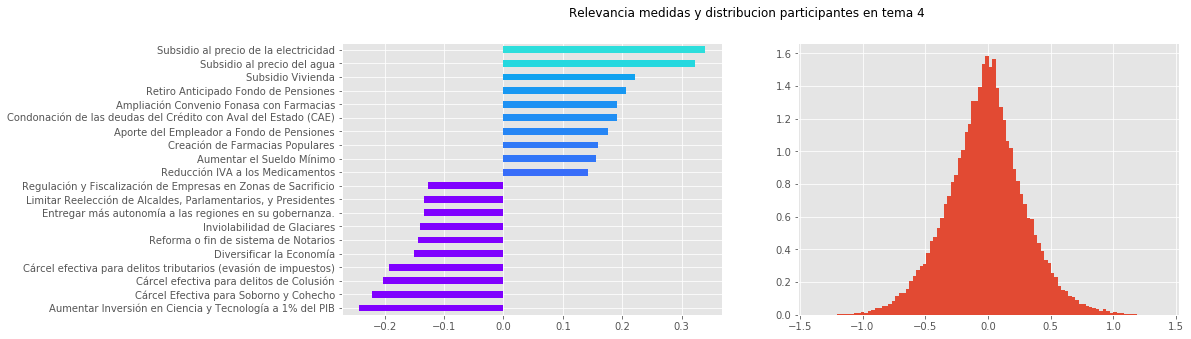

count    57326.000000
mean        -0.016697
std          0.309732
min         -1.372569
25%         -0.207214
50%         -0.012984
75%          0.170972
max          1.385314
Name: 3, dtype: float64


In [24]:
topic_analisis(3, 10, topic_sumary_df, user_topic)

El cuarto eje o tipo de votante contrapesa medidas del tipo "subsidios y aportes economicos" versus "penalizacion de abusos"

El eje de "subsidios y aportes economicos" toma temas como subsudios a servicios basicos, condonacion del CAE, mejora de pensiones y otros con el mismo foco econonico.

El eje de "penalizacion de abusos" muestra elementos relativos a carcel efectiva por delitos politico/economicos, reforma al sistema de notarios, ademas de elementos de ecologia y ciencia.

La distribucion es bastante balanceada, con un pequeño sesgo al la "penalizacion de abusos".

## Tema 5

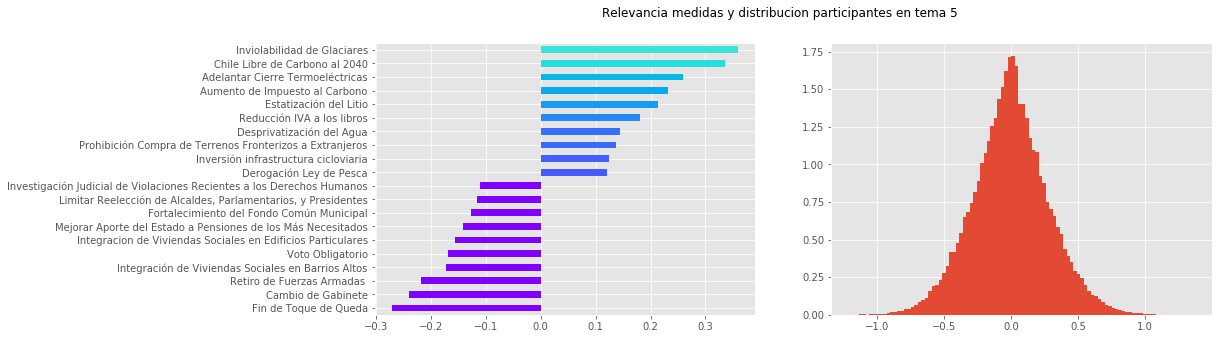

count    57326.000000
mean        -0.003598
std          0.281641
min         -1.213447
25%         -0.180803
50%         -0.004469
75%          0.171525
max          1.370693
Name: 4, dtype: float64


In [25]:
topic_analisis(4, 10, topic_sumary_df, user_topic)

El cuarto eje o tipo de votante contrapesa medidas del tipo "ecologia y estatizacion de recursos naturales" versus "integracion social" 

El eje de "ecologia" muestra iniciativas relativas a glaciares, huella de carbono y la nacionalizacion de recursos naturales como el litio y el agua.

En el eje de "integracion social" relacionados a la integracion de viviendas sociales en el barrio alto y en edificios particulares, fondo comun municipal, ademas de elementos contra las la gestion politica actual (cambio de gabinete, fin al toque de queda).

No se ve un sesgo claro en la distribucion

# Tsne encuestados

In [26]:
# genera y entrena modelo de tsne en 2 dimensiones
user_topic_embedded = TSNE(n_components=2, perplexity=100, n_iter=1000, random_state=42).fit_transform(user_topic)

In [27]:
# une las nuevas coordenadas a la data existente
user_topic_embedded_df = pd.DataFrame(user_topic_embedded,  index = data_matrix_rank.index , columns=['x','y'])
user_topic_embedded_df = user_topic_embedded_df.join(data_people.set_index('uuid'), how='left')
user_topic_embedded_df = user_topic_embedded_df.join(user_topic_df, how='left')

In [ ]:
# grafica los participantes en sus nuevas coordenadas
fig=plt.figure(figsize=(15,10))
for i in range(1,7):
    ax=fig.add_subplot(2,3,i)        
    ax.scatter(user_topic_embedded_df['x'], user_topic_embedded_df['y'], alpha = 0.01, 
            color = cm.rainbow(user_topic_embedded_df[i-1]))
    ax.set_title('Tema: {}'.format(i))

fig.suptitle('Analisis bidimensional t-sne a los participantes, color acorde a 6 principales temas') 
plt.show()

A diferencia del analisis incluyendo elementos anomalos, no es posible distinguir cluster bien formados, lo cual  apoya la idea que la preferencia a las diferentes medidas es algo fluido, sin crear grupos excesivamente homogeneos.

# ConnectaLabs AI

ConnectaLabs AI es una empresa especialista en el desarrollo de soluciones de inteligencia artificial para la comprensión del cliente. Si quieres saber más de nosotros y nuestros servicios puedes contactarnos en nuestras RRSS.

 - Email: [ai@connectalabs.ai](mailto:ai@connectalabs.ai?subject=Riots-Chile)
 - Web: [https://www.connectalabs.ai](https://www.connectalabs.ai)
 - Linkedin: [https://www.linkedin.com/company/connecta-labs-ai](https://www.linkedin.com/company/connecta-labs-ai)
 - Medium: [https://medium.com/connecta-ai](https://medium.com/connecta-ai)